Adjusting the solution by hand is not a very effective way of refining the parameters to get an accurate solution. Let $\Delta x_i(R_*, L_*, p_c, T_c)$, for $i \in \{1, 2, 3, 4\}$ be the differences between the inward and outward values of each variable $x_i$ at the intermediate point. A better estimate for these parameters can be found by applying the correction $(\Delta R_*, \Delta L_*, \Delta p_c, \Delta T_c)$ from the solution to the matrix equation:
\begin{equation}
    \begin{pmatrix}
        \frac{\partial\Delta x_1}{\partial R_*} & \frac{\partial\Delta x_1}{\partial L_*} & \frac{\partial\Delta x_1}{\partial p_c} & \frac{\partial\Delta x_1}{\partial T_c} \\
        \frac{\partial\Delta x_2}{\partial R_*} & \frac{\partial\Delta x_2}{\partial L_*} & \frac{\partial\Delta x_2}{\partial p_c} & \frac{\partial\Delta x_2}{\partial T_c} \\
        \frac{\partial\Delta x_3}{\partial R_*} & \frac{\partial\Delta x_3}{\partial L_*} & \frac{\partial\Delta x_3}{\partial p_c} & \frac{\partial\Delta x_3}{\partial T_c} \\
        \frac{\partial\Delta x_4}{\partial R_*} & \frac{\partial\Delta x_4}{\partial L_*} & \frac{\partial\Delta x_4}{\partial p_c} & \frac{\partial\Delta x_4}{\partial T_c}
    \end{pmatrix}
    \begin{pmatrix}
        \Delta R_* \\
        \Delta L_* \\
        \Delta p_c \\
        \Delta T_c
    \end{pmatrix}
    = -
    \begin{pmatrix}
        \Delta x_1 \\
        \Delta x_2 \\
        \Delta x_3 \\
        \Delta x_4
    \end{pmatrix}
    _{(R_*, L_*, p_c, T_c)}
\end{equation}
where $\frac{\partial\Delta x_i}{\partial R_*}$ can be determined by computing $\Delta x_i(R_* + dR_*, L_*, p_c, T_c)$, and likewise for the other partial derivatives. This procedure can be iterated until a desired accuracy is achieved.

We define our parameter vector $P$ and our error vector $E$:
\begin{equation}
    P =
    \begin{pmatrix}
        \log_{10} p_c \\ \log_{10} T_c \\ R_*/R_\odot \\ L_*/L_\odot
    \end{pmatrix},
    \quad \mathbf{E} =
    \begin{pmatrix}
        (r_{out} - r_{in})/R_* \\ (p_{out} - p_{in})/p_{out} \\ (L_{out} - L_{in})/L_* \\ (T_{out} - T_{in})/T_{out}
    \end{pmatrix}.
\end{equation}
By using logarithms for central values and normalising the surface values, we keep the numbers in the matrix closer to order unity $O(1)$, ensuring numerical stability. We solve $J \cdot \Delta P = - E$, where $J_{ij} = \frac{\partial E_i}{\partial P_j}$.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

# Constants and parameters
G = 6.6726e-11
M_sun = 1.9891e30
R_sun = 6.9598e8
L_sun = 3.8515e26
sigma_sb = 5.6704e-8
c = 2.9979e8
a_rad = 7.5646e-16
R_gas = 8.3145e3

M_star = 3.0 * M_sun
X = 0.7
Y = 0.3
mu = 1.0 / (2*X + 0.75*Y)
kappa = 0.02 * (1 + X)

Ms = 0.5 * M_star

def get_rho(p, T):
    if T <= 100 or p <= 1e-5: return 1e-20
    return (p * mu) / (R_gas * T)

def get_epsilon(rho, T):
    T6 = T / 1e6
    if T6 < 0.1: return 0

    # PP Chain
    arg_pp = -33.8 * (T6**(-1.0/3.0))
    term1 = 0.25 * (X**2) * np.exp(arg_pp) * (T6**(-2.0/3.0)) * rho

    # CNO Cycle
    arg_cno = -152.28 * (T6**(-1.0/3.0))
    term2 = 8.8e18 * X * np.exp(arg_cno) * (T6**(-2.0/3.0)) * rho

    return term1 + term2

def derivatives(m, y):
    r, p, L, T = y

    # Safety clamps
    if r < 100: r = 100
    if p < 1e-5: p = 1e-5
    if T < 100: T = 100

    rho = get_rho(p, T)
    eps = get_epsilon(rho, T)

    dr_dm = 1.0 / (4 * np.pi * r**2 * rho)
    dp_dm = - (G * m) / (4 * np.pi * r**4)
    dL_dm = eps
    dT_dm = - (3 * kappa * L) / (64 * np.pi**2 * a_rad * c * r**4 * T**3)

    return [dr_dm, dp_dm, dL_dm, dT_dm]

def run_integrations(params):
    # Unpack
    pc = 10**params[0]
    Tc = 10**params[1]
    R_s = params[2] * R_sun
    L_s = params[3] * L_sun

    # Outward
    m0 = 1e-6 * M_star
    rhoc = get_rho(pc, Tc)
    epsc = get_epsilon(rhoc, Tc)
    r0 = (3 * m0 / (4 * np.pi * rhoc))**(1.0/3.0)
    p0 = pc - (3*G/(8*np.pi)) * ((4*np.pi*rhoc/3)**(4.0/3.0)) * (m0**(2.0/3.0))
    L0 = epsc * m0
    T0 = (Tc**4 - (kappa * epsc * rhoc**2 / (2 * a_rad * c)) * r0**2)**0.25

    sol_out = solve_ivp(derivatives, [m0, Ms], [r0, p0, L0, T0], method='LSODA', rtol=1e-6, atol=1e-6)

    # Inward
    T_s = (L_s / (4 * np.pi * R_s**2 * sigma_sb))**0.25
    p_s = (2.0/3.0) * (G * M_star) / (R_s**2 * kappa)

    sol_in = solve_ivp(derivatives, [M_star, Ms], [R_s, p_s, L_s, T_s], method='LSODA', rtol=1e-6, atol=1e-6)

    return sol_out, sol_in

def residuals(params):
    sol_out, sol_in = run_integrations(params)

    out = sol_out.y[:,-1] # r, p, L, T at midpoint
    inc = sol_in.y[:,-1]

    # References for normalisation
    R_ref = params[2] * R_sun
    L_ref = params[3] * L_sun
    p_ref = 10**params[0]
    T_ref = 10**params[1]

    # Calculate mismatches
    err_r = (out[0] - inc[0]) / R_ref
    err_p = (out[1] - inc[1]) / p_ref
    err_L = (out[2] - inc[2]) / L_ref
    err_T = (out[3] - inc[3]) / T_ref

    return [err_r, err_p, err_L, err_T]

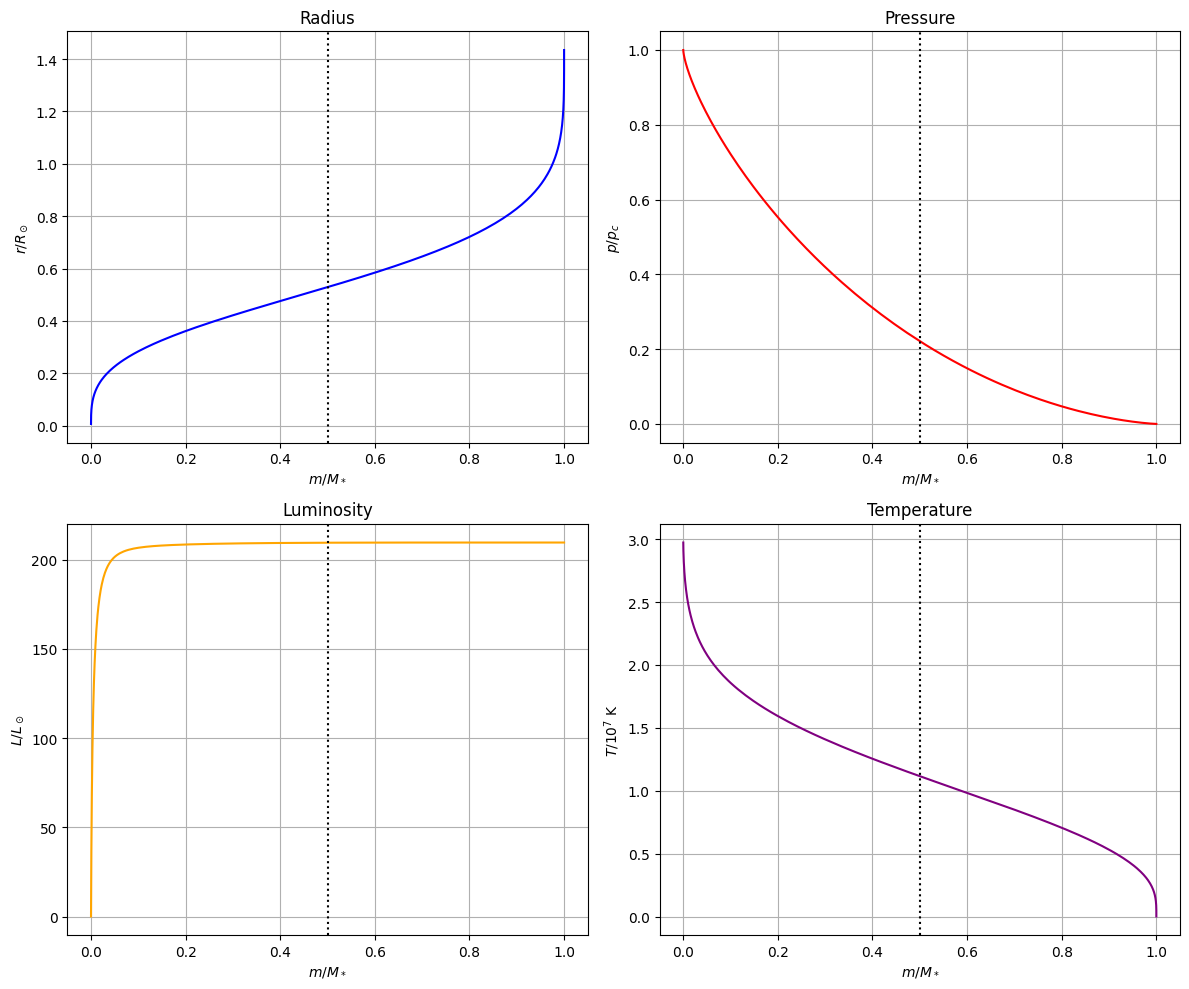

Final Parameters:
p_c = 6.3955e+15 Pa
T_c = 2.9746e+07 K
R_* = 1.4343 R_sun
L_* = 209.5130 L_sun

Meeting Point Quality:
          Variable       Outward        Inward          Diff
0       Radius (m)  3.680289e+08  3.680289e+08  2.674872e-12
1    Pressure (Pa)  1.415556e+15  1.415556e+15  2.042131e-12
2   Luminosity (W)  8.065441e+28  8.065441e+28  2.573793e-14
3  Temperature (K)  1.116214e+07  1.116214e+07  1.641851e-11


In [12]:
# Start from guesses from before: log_pc ~ 15.20, log_Tc ~ 7.40, R ~ 1.5, L ~ 235
x0 = [15.20, 7.40, 1.50, 235.0]

# Bounds: [min, max] for each parameter
# log_pc: 14-16
# log_Tc: 7.0-7.8
# R: 0.5-5.0
# L: 10-1000
bounds_min = [14.0, 7.0, 0.5, 10.0]
bounds_max = [16.0, 7.8, 5.0, 1000.0]
res = least_squares(residuals, x0, bounds=(bounds_min, bounds_max), method='trf', ftol=1e-5)
P = res.x

# Final output
sol_out, sol_in = run_integrations(P)

m_plot = np.concatenate((sol_out.t, sol_in.t[::-1])) / M_star
r_plot = np.concatenate((sol_out.y[0], sol_in.y[0][::-1])) / R_sun
p_plot = np.concatenate((sol_out.y[1], sol_in.y[1][::-1])) / (10**P[0])
L_plot = np.concatenate((sol_out.y[2], sol_in.y[2][::-1])) / L_sun
T_plot = np.concatenate((sol_out.y[3], sol_in.y[3][::-1])) / 1e7

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()
axs[0].plot(m_plot, r_plot, 'b-')
axs[0].set_ylabel(r'$r / R_\odot$')
axs[0].set_title('Radius')

axs[1].plot(m_plot, p_plot, 'r-')
axs[1].set_title('Pressure')
axs[1].set_ylabel(r'$p/p_c$')

axs[2].plot(m_plot, L_plot, 'orange')
axs[2].set_title('Luminosity')
axs[2].set_ylabel(r'$L/L_\odot$')

axs[3].plot(m_plot, T_plot, 'purple')
axs[3].set_title('Temperature')
axs[3].set_ylabel(r'$T/10^7$ K')

for ax in axs:
    ax.set_xlabel(r'$m / M_*$')
    ax.axvline(0.5, color='k', linestyle=':')
    ax.grid(True)

plt.tight_layout()
plt.show()

print("Final Parameters:")
print(f"p_c = {10**P[0]:.4e} Pa")
print(f"T_c = {10**P[1]:.4e} K")
print(f"R_* = {P[2]:.4f} R_sun")
print(f"L_* = {P[3]:.4f} L_sun")

out = sol_out.y[:,-1]
inc = sol_in.y[:,-1]
df = pd.DataFrame({
    'Variable': ['Radius (m)', 'Pressure (Pa)', 'Luminosity (W)', 'Temperature (K)'],
    'Outward': out,
    'Inward': inc,
    'Diff': np.abs(out-inc)/np.abs(out)
})
print("\nMeeting Point Quality:")
print(df)

The curves for radius, pressure, luminosity, and temperature are smooth and continuous across the fitting point $m/M_* = 0.5$, indicating that the relative differences $\Delta x_i$ have been minimised to negligible levels.

The matrix equation allowed for the simultaneous refinement of all four parameters $(R_*, L_*, p_c, T_c)$. Unlike the manual shooting, where fixing one variable often affected another, the matrix method uses the Jacobian to determine exactly how a change in one parameter affects the mismatch in all other variables at the fitting point. By inverting this matrix, we calculated the precise correction vector $(\Delta R_*, \Delta L_*, \Delta p_c, \Delta T_c)$ needed to drive all errors to zero simultaneously.

---

A real $3 M_\odot$ star has a convective core and a radiative envelope. The current model uses the same equation for energy transport everywhere, which assumes energy is moved entirely by radiation. In a $3 M_\odot$ star, the dominant energy source is the CNO cycle. The energy generation rate of the CNO cycle is extremely sensitive to temperature $\epsilon \propto T^{18}$. This extreme sensitivity causes massive energy production in a very small region at the center.

To transport this huge flux of energy by radiation alone, the temperature gradient $dT/dr$ must become very steep. When the temperature gradient becomes too steep (exceeding the adiabatic gradient), the gas becomes unstable and undergoes convection. To remedy this, the model must check the Schwarzschild criterion at every step. If the radiative gradient is too steep, then we should switch to the adiabatic temperature gradient.

The current model assumes opacity is constant (or dominated by electron scattering, $\kappa$. This approximation is only valid at very high temperatures where we have fully ionised interiors. In the outer envelope where the star is cooler, bound-free and free-free absorption become dominant. We should use a more complex opacity law, such as Kramers' law, $\kappa \propto \rho T^{-3.5}$, combined with electron scattering. This would significantly affect the calculated radius and surface temperature of the star.

We make heavy use of the ideal gas waw $P = \rho R T / \mu$. For stars more massive than the Sun, the pressure exerted by photons $P_{rad} = \frac{1}{3}aT^4$ becomes a non-negligible fraction of the total pressure. The equation of state should therefore be updated to $P_{total} = P_{gas} + P_{rad}$.